<a href="https://colab.research.google.com/github/rehman2222/AI/blob/main/Lab_Assigment_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-499017004.py:112: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill').fillna(0)


IsolationForest detected anomalies: 61112
Sequence array shape: (525570, 30, 6)
Epoch 1/20
6570/6570 ━━━━━━━━━━━━━━━━━━━━ 99s 14ms/step - loss: 0.3500 - val_loss: 0.9186
Epoch 2/20
6570/6570 ━━━━━━━━━━━━━━━━━━━━ 95s 14ms/step - loss: 0.2768 - val_loss: 0.8085
Epoch 3/20
6570/6570 ━━━━━━━━━━━━━━━━━━━━ 94s 14ms/step - loss: 0.2493 - val_loss: 1.0582
Epoch 4/20
6570/6570 ━━━━━━━━━━━━━━━━━━━━ 93s 14ms/step - loss: 0.2314 - val_loss: 2.7491
Epoch 5/20
6570/6570 ━━━━━━━━━━━━━━━━━━━━ 93s 14ms/step - loss: 0.2140 - val_loss: 1.7646
Epoch 6/20
6570/6570 ━━━━━━━━━━━━━━━━━━━━ 94s 14ms/step - loss: 0.1958 - val_loss: 1.8792
Epoch 7/20
6570/6570 ━━━━━━━━━━━━━━━━━━━━ 91s 14ms/step - loss: 0.1832 - val_loss: 1.7906
Epoch 8/20
6570/6570 ━━━━━━━━━━━━━━━━━━━━ 92s 14ms/step - loss: 0.1759 - val_loss: 1.5912
Epoch 9/20
6570/6570 ━━━━━━━━━━━━━━━━━━━━ 93s 14ms/step - loss: 0.1608 - val_loss: 1.0279
Epoch 10/20
6570/6570 ━━━━━━━━━━━━━━━━━━━━ 92s 14ms/step - loss: 0.1505 - val_loss: 0.9686
Epoch 11/20
6570/65

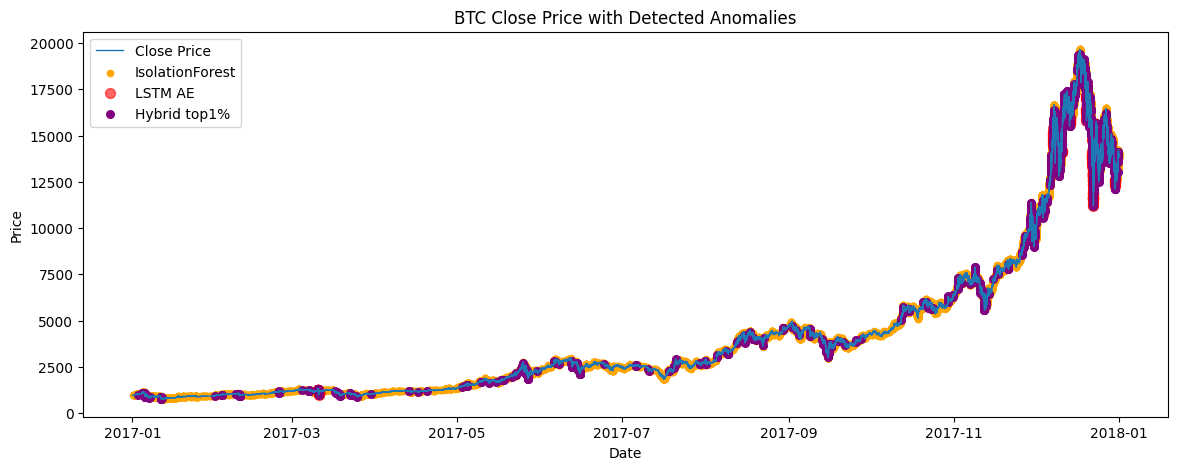

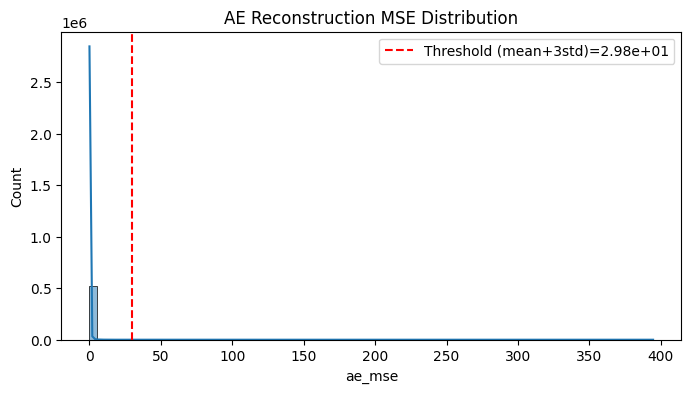

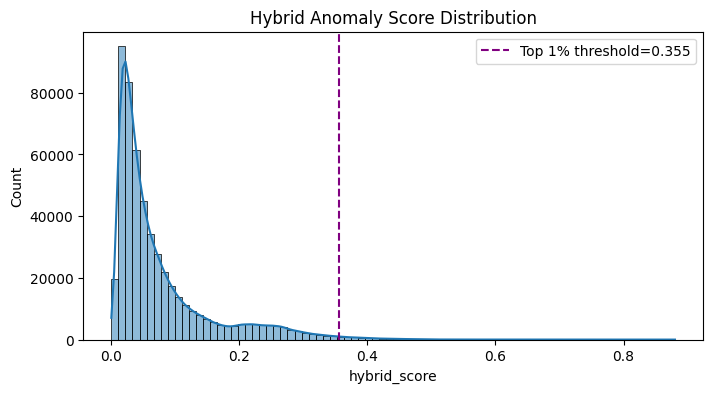

Saved results to btc_anomaly_results.csv
Summary: {'total_points': 525599, 'iso_anomalies': 61112, 'ae_anomalies': 500, 'hybrid_union': 61112, 'hybrid_intersection': 500, 'hybrid_top1pct': 5256}


In [3]:
# BTC Anomaly Detection Pipeline
# Works with CSV that has columns:
# unix, date, symbol, open, high, low, close, Volume BTC, Volume USD
#
# Colab-ready. If running in Colab, upload your CSV and set `csv_path`.
# Example: from google.colab import files; uploaded = files.upload()

# ----------------------------
# 1. Imports
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras import layers, models
from datetime import datetime

# ----------------------------
# 2. User: set CSV path
# ----------------------------
# Replace this with your file path or upload in Colab and update path.
csv_path = "/content/drive/MyDrive/AI Assignment/BTC-2017min.csv.zip"  # <<-- change to your filename

# ----------------------------
# 3. Load CSV (handles spaces in column names)
# ----------------------------
df = pd.read_csv(csv_path)

# Normalize column names (strip)
df.columns = [c.strip() for c in df.columns]

expected = ['unix','date','symbol','open','high','low','close','Volume BTC','Volume USD']
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns in CSV: {missing}")

# ----------------------------
# 4. Basic preprocessing
# ----------------------------
# parse date, sort, set index
try:
    df['date'] = pd.to_datetime(df['date'])
except:
    # try unix if 'date' parse fails
    df['date'] = pd.to_datetime(df['unix'], unit='s')

df = df.sort_values('date').reset_index(drop=True)
df.set_index('date', inplace=True)

# convert numeric columns (some CSVs have strings)
for col in ['open','high','low','close','Volume BTC','Volume USD']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# drop rows with NaNs in price
df = df.dropna(subset=['open','high','low','close'])

# ----------------------------
# 5. Feature engineering (tabular features)
# ----------------------------
data = df.copy()

# basic returns
data['return'] = data['close'].pct_change().fillna(0)
data['log_return'] = np.log1p(data['return'])

# price range and normalized range
data['range'] = (data['high'] - data['low']) / (data['open'] + 1e-9)

# typical price
data['typ_price'] = (data['high'] + data['low'] + data['close']) / 3

# rolling features
for w in [3, 6, 12, 24]:
    data[f'ma_{w}'] = data['close'].rolling(window=w, min_periods=1).mean()
    data[f'std_{w}'] = data['close'].rolling(window=w, min_periods=1).std().fillna(0)
    data[f'vol_ma_{w}'] = data['Volume BTC'].rolling(window=w, min_periods=1).mean()

# volatility
data['volatility_24'] = data['return'].rolling(window=24, min_periods=1).std().fillna(0)

# relative volume
data['vol_ratio'] = data['Volume BTC'] / (data['vol_ma_24'] + 1e-9)

# normalized price deviation (z-score over 24)
data['zscore_24'] = (data['close'] - data['ma_24']) / (data['std_24'] + 1e-9)

# MACD (simple)
ema12 = data['close'].ewm(span=12, adjust=False).mean()
ema26 = data['close'].ewm(span=26, adjust=False).mean()
data['macd'] = ema12 - ema26
data['macd_sig'] = data['macd'].ewm(span=9, adjust=False).mean()

# RSI helper
def compute_RSI(series, period=14):
    delta = series.diff().fillna(0)
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.ewm(com=period-1, adjust=False).mean()
    ma_down = down.ewm(com=period-1, adjust=False).mean()
    rs = ma_up / (ma_down + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['rsi_14'] = compute_RSI(data['close'], 14)

# fill remaining NaNs
data = data.fillna(method='ffill').fillna(method='bfill').fillna(0)

# ----------------------------
# 6. Prepare feature matrix for IsolationForest
# ----------------------------
feature_cols = [
    'return','log_return','range','typ_price',
    'ma_3','ma_6','ma_12','ma_24',
    'std_3','std_6','std_12','std_24',
    'vol_ma_3','vol_ma_6','vol_ma_12','vol_ma_24',
    'volatility_24','vol_ratio','zscore_24','macd','macd_sig','rsi_14'
]

X = data[feature_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------------
# 7. Model 1: Isolation Forest (tabular anomalies)
# ----------------------------
# The 'behaviour' parameter is deprecated and removed in newer scikit-learn versions.
# The code below attempts to handle this, but the initial instantiation was problematic.
# Removed the line that was causing the TypeError.

# To avoid compatibility issues, we will rely solely on the try/except block.
try:
    iso = IsolationForest(n_estimators=200, contamination='auto', random_state=42)
except TypeError:
    # Fallback for older scikit-learn versions that might not support 'auto' contamination
    iso = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)

iso.fit(X_scaled)
iso_scores = iso.decision_function(X_scaled)     # higher = normal, lower = anomaly
iso_pred = iso.predict(X_scaled)                 # -1 anomaly, 1 normal
data['iso_score'] = iso_scores
data['iso_anomaly'] = (iso_pred == -1).astype(int)

print("IsolationForest detected anomalies:", data['iso_anomaly'].sum())

# ----------------------------
# 8. Model 2: LSTM Autoencoder (sequence/reconstruction anomaly)
# ----------------------------
# Build sequences of length seq_len using close + a few features
seq_len = 30  # 30 time-steps; adjust depending on sampling freq
seq_features = ['close','Volume BTC','return','zscore_24','macd','rsi_14']
S = data[seq_features].values

# scale sequence features separately
seq_scaler = StandardScaler()
S_scaled = seq_scaler.fit_transform(S)

# create overlapping sequences
def create_sequences(arr, seq_len):
    seqs = []
    for i in range(len(arr) - seq_len + 1):
        seqs.append(arr[i:i+seq_len])
    return np.array(seqs)

seqs = create_sequences(S_scaled, seq_len)
print("Sequence array shape:", seqs.shape)  # (n_samples, seq_len, n_features)

# train/val split for autoencoder
train_size = int(0.8 * len(seqs))
x_train = seqs[:train_size]
x_val = seqs[train_size:]

# LSTM Autoencoder model
tf.keras.backend.clear_session()
input_shape = x_train.shape[1:]  # (seq_len, n_features)

ae = models.Sequential([
    layers.Input(shape=input_shape),
    layers.LSTM(64, activation='tanh', return_sequences=True),
    layers.LSTM(32, activation='tanh', return_sequences=False),
    layers.RepeatVector(input_shape[0]),
    layers.LSTM(32, activation='tanh', return_sequences=True),
    layers.LSTM(64, activation='tanh', return_sequences=True),
    layers.TimeDistributed(layers.Dense(input_shape[1]))
])

ae.compile(optimizer='adam', loss='mse')
history = ae.fit(
    x_train, x_train,
    epochs=20,
    batch_size=64,
    validation_data=(x_val, x_val),
    verbose=1
)

# compute reconstruction errors for all sequences
reconstructions = ae.predict(seqs)
mse = np.mean(np.mean((reconstructions - seqs)**2, axis=2), axis=1)  # MSE per sequence

# align MSE back to original time index: assign each sequence's error to its last timestamp
mse_index = data.index[seq_len - 1:]  # first seq ends at index seq_len-1
mse_series = pd.Series(mse, index=mse_index)
data['ae_mse'] = mse_series.reindex(data.index).fillna(0)

# choose threshold as mean + 3*std of validation MSE
val_reconstructions = ae.predict(x_val)
val_mse = np.mean(np.mean((val_reconstructions - x_val)**2, axis=2), axis=1)
thresh = val_mse.mean() + 3 * val_mse.std()
data['ae_anomaly'] = (data['ae_mse'] > thresh).astype(int)

print("LSTM Autoencoder detected anomalies:", data['ae_anomaly'].sum())
print("AE MSE threshold:", thresh)

# ----------------------------
# 9. Hybrid: combine results
# ----------------------------
# Options: union (flag if either model flags), intersection (both), weighted score
data['hybrid_union'] = ((data['iso_anomaly'] == 1) | (data['ae_anomaly'] == 1)).astype(int)
data['hybrid_intersection'] = ((data['iso_anomaly'] == 1) & (data['ae_anomaly'] == 1)).astype(int)

# Weighted score: normalize iso_score and ae_mse, lower scores = more anomalous for iso (decision_function)
# For convenience invert iso_score so high -> anomaly score
iso_s = (data['iso_score'].max() - data['iso_score'])  # larger = more anomalous
# normalize both to 0-1
iso_norm = (iso_s - iso_s.min()) / (iso_s.max() - iso_s.min() + 1e-9)
ae_norm = (data['ae_mse'] - data['ae_mse'].min()) / (data['ae_mse'].max() - data['ae_mse'].min() + 1e-9)
data['hybrid_score'] = 0.5 * iso_norm + 0.5 * ae_norm

# pick top anomalies by hybrid_score (for example top 1% as anomalies)
pct = 0.01
threshold_top = data['hybrid_score'].quantile(1 - pct)
data['hybrid_score_anomaly_top1pct'] = (data['hybrid_score'] >= threshold_top).astype(int)

print("Hybrid (union) anomalies:", data['hybrid_union'].sum())
print("Hybrid (intersection) anomalies:", data['hybrid_intersection'].sum())
print(f"Hybrid (top {int(pct*100)}%) anomalies:", data['hybrid_score_anomaly_top1pct'].sum())

# ----------------------------
# 10. Visualizations
# ----------------------------
plt.figure(figsize=(14,5))
plt.plot(data.index, data['close'], label='Close Price', linewidth=1)
plt.scatter(data.index[data['iso_anomaly']==1], data['close'][data['iso_anomaly']==1], color='orange', label='IsolationForest', s=20)
plt.scatter(data.index[data['ae_anomaly']==1], data['close'][data['ae_anomaly']==1], color='red', label='LSTM AE', s=50, alpha=0.6) # Increased size and added transparency
plt.scatter(data.index[data['hybrid_score_anomaly_top1pct']==1], data['close'][data['hybrid_score_anomaly_top1pct']==1], color='purple', label='Hybrid top1%', s=30)
plt.title('BTC Close Price with Detected Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot AE reconstruction error distribution
plt.figure(figsize=(8,4))
sns.histplot(data['ae_mse'].replace(0, np.nan).dropna(), bins=80, kde=True)
plt.axvline(thresh, color='red', linestyle='--', label=f'Threshold (mean+3std)={thresh:.2e}')
plt.title('AE Reconstruction MSE Distribution')
plt.legend()
plt.show()

# Plot hybrid score distribution
plt.figure(figsize=(8,4))
sns.histplot(data['hybrid_score'], bins=80, kde=True)
plt.axvline(threshold_top, color='purple', linestyle='--', label=f'Top {int(pct*100)}% threshold={threshold_top:.3f}')
plt.title('Hybrid Anomaly Score Distribution')
plt.legend()
plt.show()

# ----------------------------
# 11. Save results
# ----------------------------
out_csv = "btc_anomaly_results.csv"
save_cols = ['unix','symbol','open','high','low','close','Volume BTC','Volume USD'] + feature_cols + ['iso_score','iso_anomaly','ae_mse','ae_anomaly','hybrid_score','hybrid_score_anomaly_top1pct','hybrid_union','hybrid_intersection']
# ensure columns exist in data
save_cols = [c for c in save_cols if c in data.columns]
data[save_cols].to_csv(out_csv, index=True)
print("Saved results to", out_csv)

# ----------------------------
# 12. Summary counts
# ----------------------------
summary = {
    'total_points': len(data),
    'iso_anomalies': int(data['iso_anomaly'].sum()),
    'ae_anomalies': int(data['ae_anomaly'].sum()),
    'hybrid_union': int(data['hybrid_union'].sum()),
    'hybrid_intersection': int(data['hybrid_intersection'].sum()),
    'hybrid_top1pct': int(data['hybrid_score_anomaly_top1pct'].sum())
}
print("Summary:", summary)

# If you have labeled anomalies (ground truth column like 'label' with 1=anomaly),
# you can compute precision/recall by comparing e.g. data['iso_anomaly'] vs data['label'].
# Example:
# if 'label' in data.columns:
#     print(precision_recall_fscore_support(data['label'], data['hybrid_union'], average='binary'))
